In [41]:
# === Imports and Dataset Loading ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle

# Load dataset
df = pd.read_csv('data/Telco_Customer_Churn_Dataset .csv')

print("Shape of dataset:", df.shape)
df.info()


Shape of dataset: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

In [42]:
# === Data Preprocessing & Feature Engineering ===

# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Encode target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Feature engineering
df['HighCharges'] = (df['MonthlyCharges'] > 70).astype(int)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
df['SeniorHighCharges'] = ((df['SeniorCitizen']==1) & (df['HighCharges']==1)).astype(int)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=['0-12','13-24','25-48','49-72'], include_lowest=True)

# Drop ID
df = df.drop(columns=['customerID'])

print("Processed dataset shape:", df.shape)


Processed dataset shape: (7043, 23)


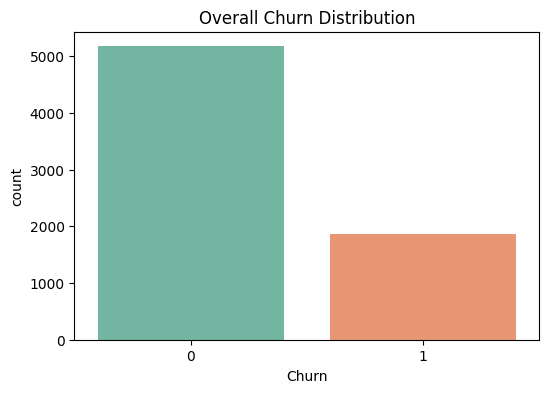

Churn Rate: 26.54%


In [43]:
# === EDA: Churn Distribution ===
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title("Overall Churn Distribution")
plt.show()
print(f"Churn Rate: {df['Churn'].mean()*100:.2f}%")


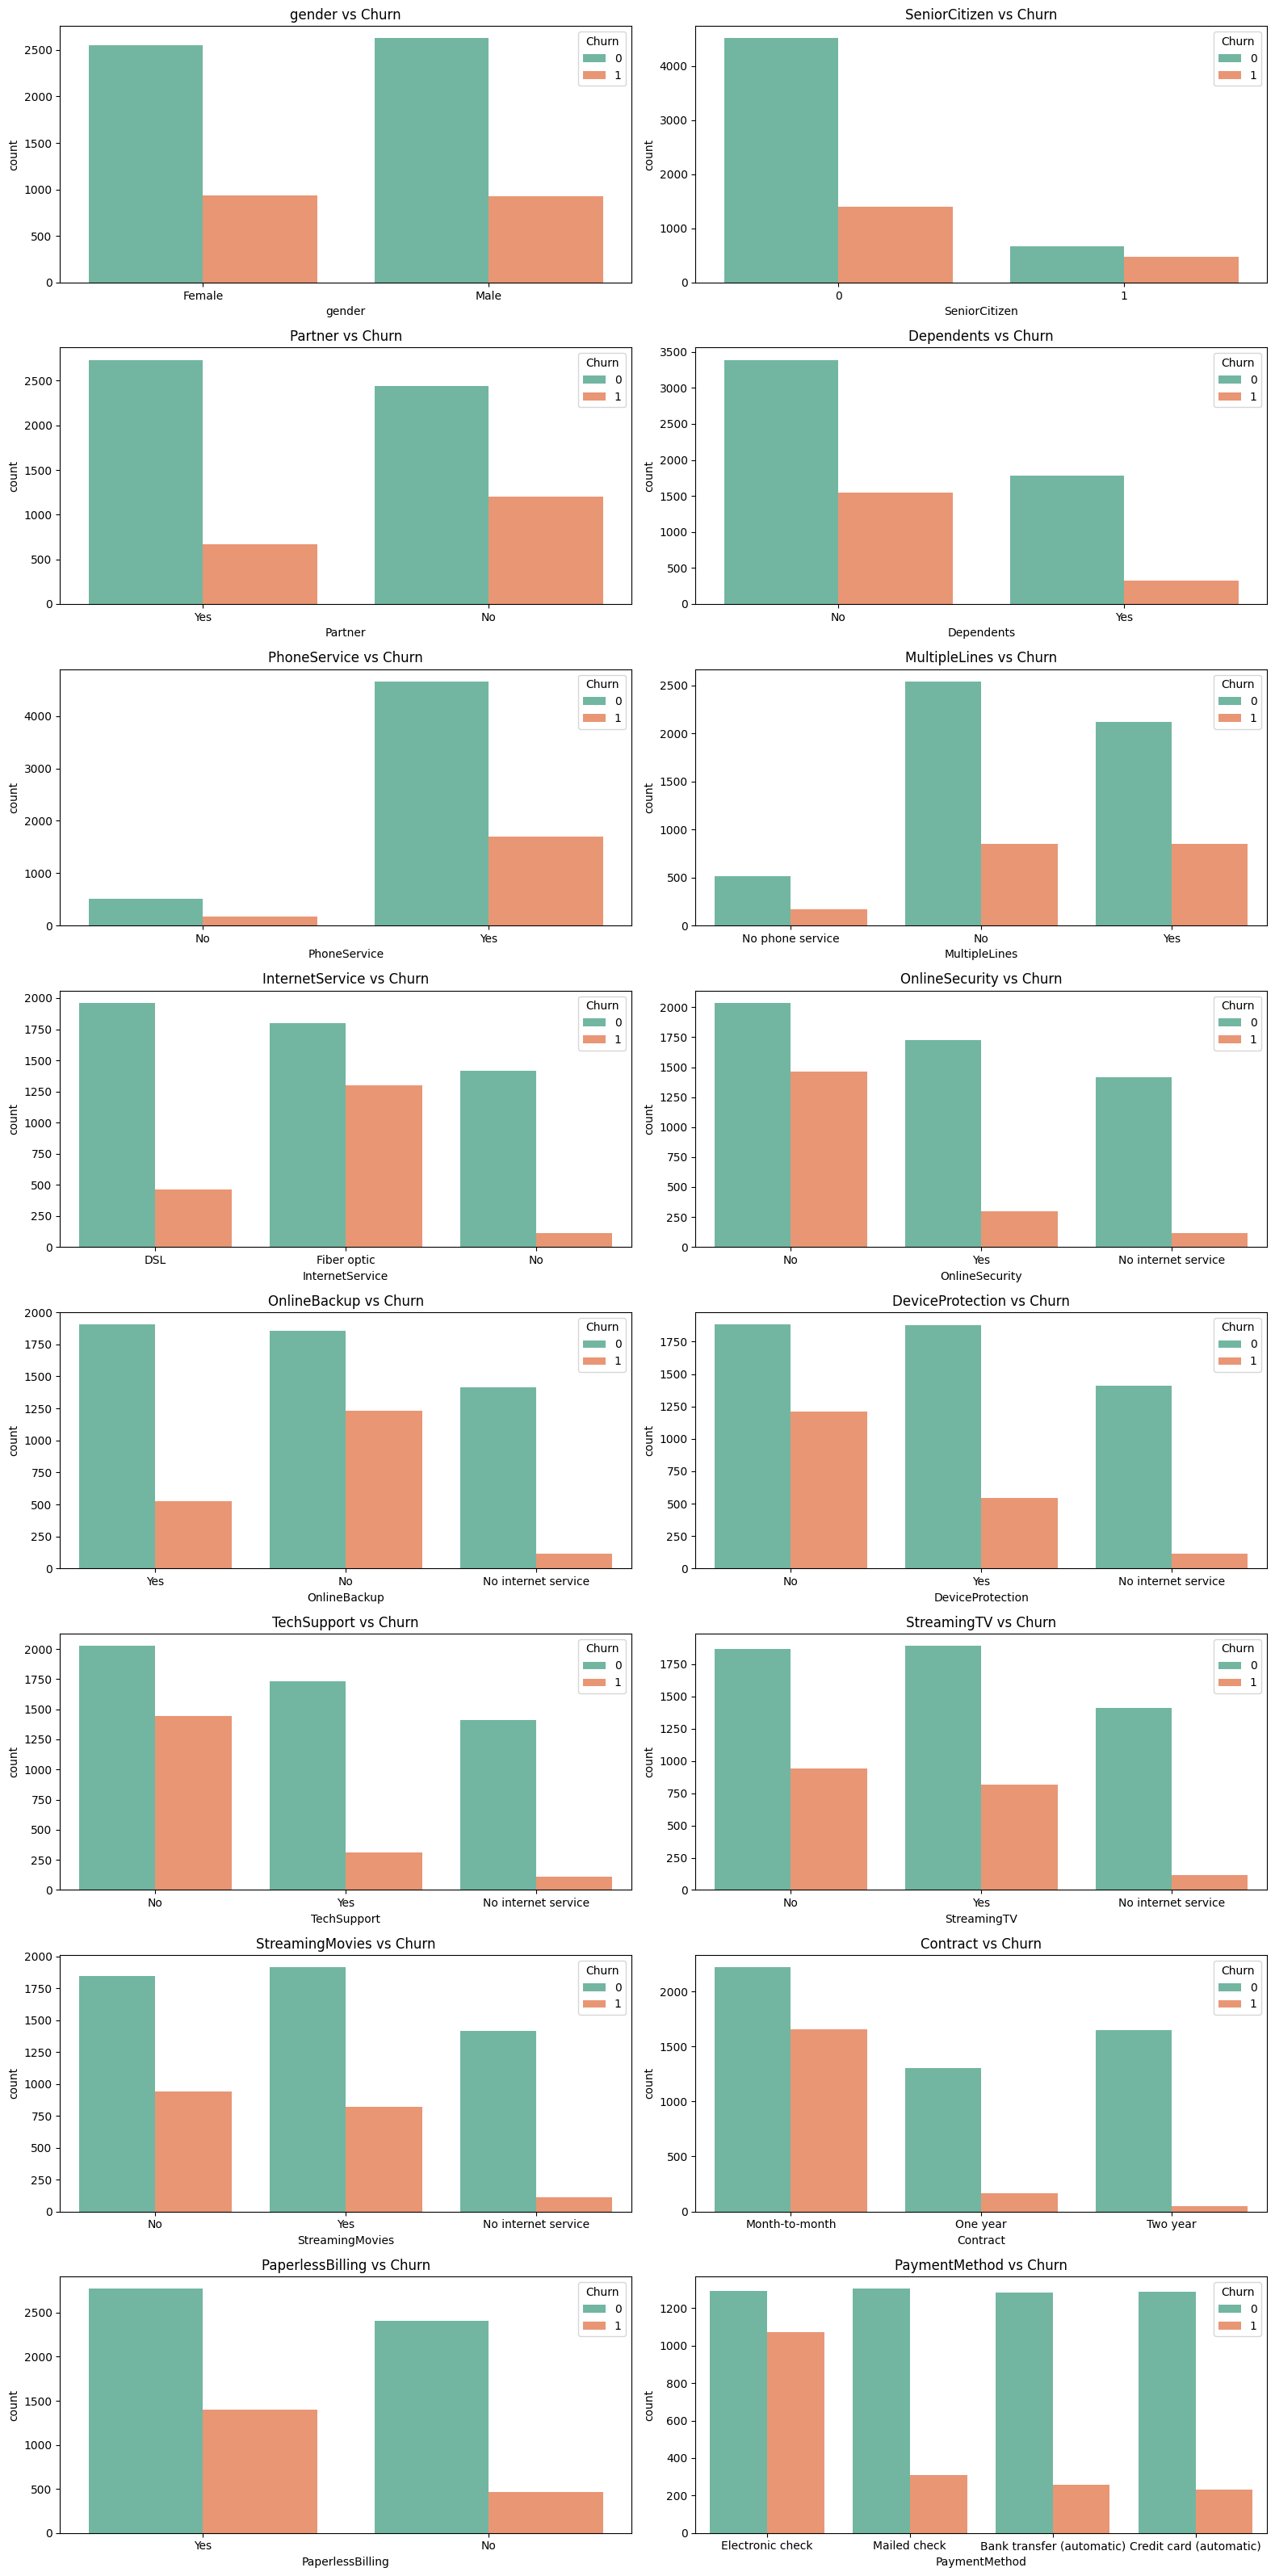

In [44]:
# === EDA: Categorical Features vs Churn (Grouped Subplots) ===
categorical_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService',
                    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                    'Contract','PaperlessBilling','PaymentMethod']

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(16, 32))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f"{col} vs Churn")

plt.tight_layout()
plt.show()


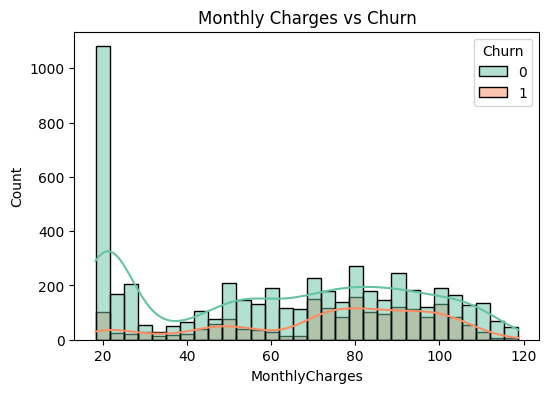

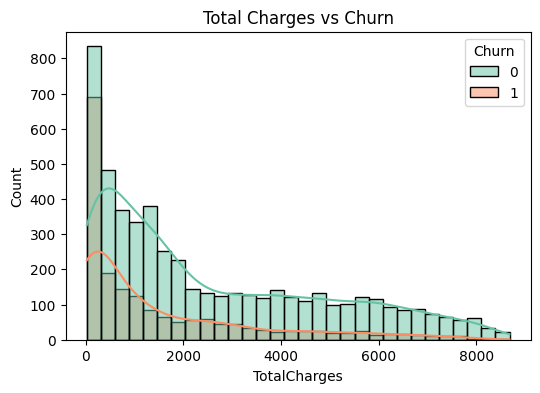

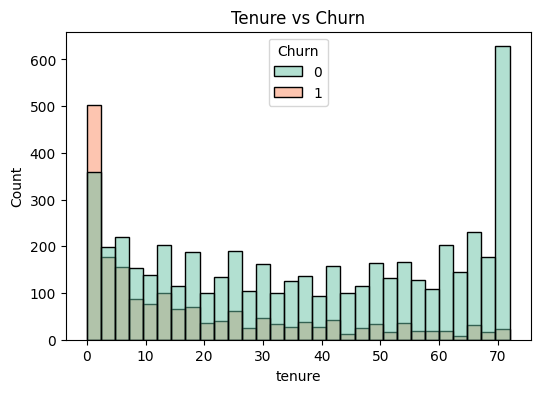

In [45]:
# === EDA: Financial & Tenure Analysis ===

# Monthly Charges Distribution
plt.figure(figsize=(6,4))
sns.histplot(df, x='MonthlyCharges', hue='Churn', kde=True, palette='Set2', bins=30)
plt.title("Monthly Charges vs Churn")
plt.show()

# Total Charges Distribution
plt.figure(figsize=(6,4))
sns.histplot(df, x='TotalCharges', hue='Churn', kde=True, palette='Set2', bins=30)
plt.title("Total Charges vs Churn")
plt.show()

# Tenure Distribution
plt.figure(figsize=(6,4))
sns.histplot(df, x='tenure', hue='Churn', kde=False, palette='Set2', bins=30)
plt.title("Tenure vs Churn")
plt.show()


In [46]:
# === Train-Test Split ===

y = df['Churn']
X = df.drop(columns=['Churn'])
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaler for LR
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape, "Test size:", X_test.shape)



Train size: (5634, 35) Test size: (1409, 35)


In [47]:
# === Logistic Regression (Baseline) ===
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# === Random Forest (Baseline) ===
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))



Logistic Regression Results:
Accuracy: 0.7955997161107168
Recall: 0.5187165775401069
ROC AUC: 0.8411377199100984

Random Forest Results:
Accuracy: 0.794180269694819
Recall: 0.5080213903743316
ROC AUC: 0.8252357332919992


In [48]:
# === Class Balancing with SMOTE ===
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())

# Logistic Regression with Balanced Weights
lr_bal = LogisticRegression(max_iter=200, class_weight='balanced')
lr_bal.fit(X_train_scaled, y_train)
print("\nBalanced Logistic Regression Recall:", recall_score(y_test, lr_bal.predict(X_test_scaled)))

# Random Forest with Balanced Weights
rf_bal = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_bal.fit(X_train, y_train)
print("Balanced RF Recall:", recall_score(y_test, rf_bal.predict(X_test)))



Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64

Balanced Logistic Regression Recall: 0.7887700534759359
Balanced RF Recall: 0.4946524064171123


In [49]:
# === Random Forest Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                    param_grid, cv=3, scoring='recall', n_jobs=-1)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

rf_best = grid.best_estimator_
y_pred_best = rf_best.predict(X_test)
print("Tuned RF Recall:", recall_score(y_test, y_pred_best))


Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuned RF Recall: 0.7513368983957219


In [50]:
# === XGBoost Classifier ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                              scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
                              random_state=42)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Results:
Accuracy: 0.7558552164655784
Recall: 0.6524064171122995
ROC AUC: 0.8240628794337234


In [54]:
# === Threshold Tuning for Recall ===
from numpy import arange

best_recall = 0
best_thresh = 0.5
for thresh in arange(0.1, 0.9, 0.05):
    pred_thresh = (y_proba_lr >= thresh).astype(int)
    rec = recall_score(y_test, pred_thresh)
    if rec > best_recall:
        best_recall, best_thresh = rec, thresh

print(f"Best Threshold: {best_thresh}, Recall: {best_recall:.3f}")


Best Threshold: 0.1, Recall: 0.947


In [55]:
# === User Input Prediction ===

def predict_churn(input_data, model, scaler=None, scale=False):
    user_df = pd.DataFrame([input_data])
    user_df = pd.get_dummies(user_df, drop_first=True)
    user_df = user_df.reindex(columns=X.columns, fill_value=0)
    if scale and scaler:
        user_df = scaler.transform(user_df)
    prediction = model.predict(user_df)[0]
    probability = model.predict_proba(user_df)[0][1]
    print("Prediction:", "Churn (1)" if prediction == 1 else "No Churn (0)")
    print(f"Churn Probability: {probability:.2f}")

# Example
user_input = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 5,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 85.0,
    'TotalCharges': 400.0,
    'HighCharges': 1,
    'SeniorHighCharges': 0,
    'TenureGroup': '0-12'
}

predict_churn(user_input, xgb_model)  # Example using XGBoost


Prediction: No Churn (0)
Churn Probability: 0.13


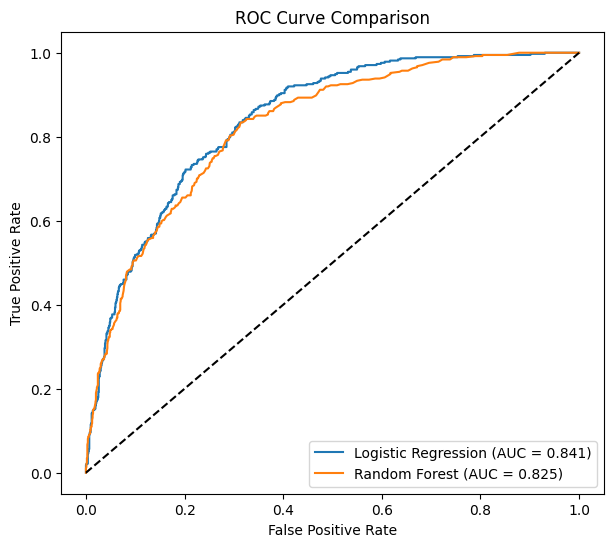

In [51]:
# === ROC Curve Comparison ===
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = %.3f)" % roc_auc_score(y_test, y_proba_lr))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = %.3f)" % roc_auc_score(y_test, y_proba_rf))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [52]:
# === Model Persistence and Reload Demo ===

# Save models
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Reload and test Logistic Regression model
with open("logistic_model.pkl", "rb") as f:
    lr_loaded = pickle.load(f)

sample_pred = lr_loaded.predict(X_test_scaled[:5])
print("Sample predictions from reloaded Logistic Regression:", sample_pred)


Sample predictions from reloaded Logistic Regression: [0 1 0 0 0]


In [58]:
# === User Input Prediction ===

# Function to take user input and predict churn
def predict_churn(input_data, model, scaler=None, scale=False):
    """
    input_data: dict with keys as feature names and values as user inputs
    model: trained model (Logistic Regression or Random Forest)
    scaler: fitted scaler object if scaling is required
    scale: boolean, whether to apply scaling (True for Logistic Regression)
    """
    # Convert dict to DataFrame
    user_df = pd.DataFrame([input_data])
    
    # Apply one-hot encoding with training feature alignment
    user_df = pd.get_dummies(user_df, drop_first=True)
    user_df = user_df.reindex(columns=X.columns, fill_value=0)
    
    # Apply scaling if needed
    if scale and scaler:
        user_df = scaler.transform(user_df)
    
    # Predict
    prediction = model.predict(user_df)[0]
    probability = model.predict_proba(user_df)[0][1]
    
    print("Prediction:", "Churn (1)" if prediction == 1 else "No Churn (0)")
    print(f"Churn Probability: {probability:.2f}")

# Example user input
user_input = {
    'gender': 'Female',
    'SeniorCitizen': 1,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 5.0,
    'TotalCharges': 100.0,
    'HighCharges': 1,
    'SeniorHighCharges': 1,
    'TenureGroup': '0-12'
}

# Use Logistic Regression for prediction
predict_churn(user_input, lr, scaler=scaler, scale=True)


Prediction: No Churn (0)
Churn Probability: 0.46
